Tutorial: A Chemistry Solver from Scratch
=========================================

This tutorial walks you through the steps to create a new chemical kinetic rate
equation solver.  These solvers all utilize very similar structures for
calculating the right hand side and the Jacobian, and will export a
standardized API to those functions.  

While Dengo provides a number of pre-packaged rate equations, species, rate
coefficients and cooling functions, here we provide the necessary steps in
order to create new species and rates from scratch.

## Defining a Species

We start by defining individual species.  This can be done inside a python
module of your choosing, which we will run at the end to output our new
network.  Species are defined by a small number of attributes:

 * Name (which will be used in cooling functions and internally to the solver)
 * Number: Mostly unused except when handling ions.
 * Atomic weight (in integer AMU)
 * Number of free electrons that is contributes

This information is used when calculating things like the contribution of a
species to the number density.
We now have three symbolic "species" objects for hydrogen, ionized hydrogen,
and electrons.  Note that Dengo will happily create ions for species defined in
the CHIANTI database.

In [1]:
from dengo.reaction_classes import AtomicSpecies, MolecularSpecies
from dengo.chemical_network import species_registry

HI = AtomicSpecies('H', 0.0)
HII = AtomicSpecies("H", 1.0)
H2I = MolecularSpecies("H2", 2.01588, 0.0)
de  = species_registry['de']

In the above example we utilize the `AtomicSpecies` and `MolecularSpecies`. `Dengo` will try to look for the constituent elements based on the expression from the periodic table, and assign them with appropriate weights. These elements are automatically register to `dengo.reaction_classes.species_registry`. 

Yeah you have successfully created your `ChemicalSpecies` in `Dengo`!

In [2]:
species_registry

{'ge': Species: ge,
 'de': Species: de,
 'H_1': Species: H_1,
 'H_2': Species: H_2,
 'H2_1': Species: H2_1}

Creating Reactions
------------------
Once we have the species in hand, we can then specify the reactions between these different species. Consider a simple reaction where ionized hydrogen atom recombines with an electron and gives a neural Hydrogen atom:
$$ \mathrm{H^+ + e^- \rightarrow H} $$ 
`dengo.reaction_classes.reaction` is primarily composed of:
- the name of the reaction:
```python
k01
```
- input species: 
```python
[(1, "HII"), (1, "de")]
 ```
- output species: 
```python
[(1, "HI")]
```
- reaction rates: which may depends on the temperature of the medium

In [3]:
from dengo.reaction_classes import reaction
from dengo.chemical_network import reaction_registry
@reaction('k02', [  (1,HII),   (1,de)], [   (1,HI),         ])
def rxn(state):
    _i1 = (state.T > 5500)
    _i2 = ~_i1
    vals = np.exp(-28.61303380689232
                  - 0.7241125657826851*state.logtev
                  - 0.02026044731984691*state.logtev**2
                  - 0.002380861877349834*state.logtev**3
                  - 0.0003212605213188796*state.logtev**4
                  - 0.00001421502914054107*state.logtev**5
                  + 4.989108920299513e-6*state.logtev**6
                  + 5.755614137575758e-7*state.logtev**7
                  - 1.856767039775261e-8*state.logtev**8
                  - 3.071135243196595e-9*state.logtev**9)

    #vals[_i2] = (1.54e-9*(1.+0.3/np.exp(8.099328789667/state.tev[_i2]))
    #              / (np.exp(40.49664394833662/state.tev[_i2])*state.tev[_i2]**1.5)
    #              + 3.92e-13/state.tev[_i2]**0.6353)

    vals[_i2] = 3.92e-13 / state.tev[_i2]**0.6353

    return vals

Similar to species, the reaction is registered in the `dengo.chemical_network.reaction_registry`, and the `dengo.reaction_classes.Reaction` is accesible through the reaction registry.

In [4]:
reaction_registry['k02'], type(reaction_registry['k02'])

(k02 : 1*H_2 + 1*de => 1*H_1, dengo.reaction_classes.Reaction)

Cooling Functions
-----------------
The release/ absorption of energy via various physical process would modify the thermal state of the medium, which might in turn accelerates/ terminates further reactions. Keeping track of the thermal energy through the course of evolution is quintessential to the accurate modeling of the process. 

`<dengo.reaction_classes.CoolingAction>` is composed of:
- name
- the cooling equation
- cooling rate

In [5]:
from dengo.reaction_classes import cooling_action
from dengo.chemical_network import cooling_registry

# -- reHII --
@cooling_action("reHII", "-reHII * HII * de")
def cool(eq):
    @eq.table
    def reHII(state):
        # (from Hui and Gnedin 1997)
        lambdaHI = 2.0 * 157807e0 / state.T
        vals = 1.778e-29 * state.T * lambdaHI**1.965 / \
         (1.0e0 + (lambdaHI/0.541)**0.502)**2.697
        return vals

Finally, we have our chemical species, reactions, cooling functions ready!

Creating a Network
------------------
We can now assemble them together in this `ChemicalNetwork`. This object helps us do all the neccessary computations to arrive at the symbolic **rhs** and **jacobian** functions. Which ultimately eases us of the process of deriving them by hand.

In our example with only one reaction, everything will eventually be recombined to form neural hydrogen.
$$ \mathrm{ H^+ + e^- \rightarrow H} $$

\begin{align*}
\mathrm{
\frac{d H}{dt} = k02(T) \,  H^+ \, e^- \\
\frac{d  H^+}{dt} = - k02(T) \,  H^+ \, e^- \\
\frac{d e^-}{dt} = - k02(T) \,  H^+ \, e^- \\
}
\end{align*}

We can do a quick sanity check on the conservation of the species $H$ and the charge $e^-$ and the equation above apparently satisfies our conservation law.
$$\frac{d}{dt} (H + H^+) = 0$$ 
$$\frac{d}{dt} (H^+ -e^-) = 0 $$

In [6]:
from dengo.chemical_network import ChemicalNetwork
simpleNetwork = ChemicalNetwork()
simpleNetwork.add_reaction("k02")
simpleNetwork.add_cooling("reHII")
simpleNetwork.init_temperature((1e0, 1e8))
simpleNetwork.enforce_conservation = True

Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1


Let's see what `ChemicalNetwork` is capable of doing!

{'k02': k02 : 1*H_2 + 1*de => 1*H_1}

In [8]:
simpleNetwork.cooling_actions

{'reHII': <dengo.reaction_classes.CoolingAction at 0x7f7e78ce8d00>}

In [9]:
simpleNetwork.required_species

{Species: H_1, Species: H_2, Species: de, Species: ge}

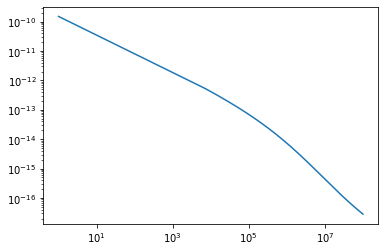

In [23]:
import numpy as np
import matplotlib.pyplot as plt

f, ax = plt.subplots()
for name, reaction in simpleNetwork.reactions.items():
    ax.loglog(simpleNetwork.T, reaction.coeff_fn(simpleNetwork))

In [22]:
coolaction.equation

-reHII_reHII[i]*H_2*de

`ChemicalNetwork.species_total`
------------------

In [10]:
dHI_dt = simpleNetwork.species_total("H_1")
dHII_dt = simpleNetwork.species_total("H_2")
de_dt  = simpleNetwork.species_total("de")